In [1]:
#external packages
import numpy as np
import math
from astropy import units as u
import astropy.coordinates as coord
from astropy.table import Table
from astropy.io import fits
import time
from numpy.lib.recfunctions import append_fields
from astropy.cosmology import FlatLambdaCDM,Planck15
from matplotlib.backends.backend_pdf import PdfPages
import sys
import random
%load_ext autoreload

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

sys.path.append('/home/almhatre/data')

In [2]:
import AGNclustering.kNN_functions as k
from AGNclustering.KNN_stuff import CDFkNN_rp_pi
from AGNclustering.kNN_error import kNN_ratio_error, block_test, kNN_chi_squared,kNN_diff_error,chop_cdf, angular_chop_cdf
from AGNclustering.utils import z_to_cdist
from AGNclustering.wppi_utils import control_mult_var,control_var
from AGNclustering.angular_kNN import CDFkNN_theta

In [3]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
data_directory = '/home/almhatre/data/BASS/'
cat = Table.read(data_directory + 'data_dr2.csv',format='csv')
agnt =np.array(cat)
agn = agnt[ (agnt['L210']>42.5) & (agnt['z']>.01)&(agnt['z']<=.1) ]
t = Table.read(data_directory +'2mrs_noAGN.csv',format='csv')
gal =np.array(t)
gal=gal[(gal['z']>.01)&(gal['z']<=.1)] #Limit redshifts to same range as AGN
agn.dtype.names

('col0',
 'bat_index',
 'Counterpart',
 'Type',
 'z',
 'Mbh',
 'Method',
 'Edd_rat',
 'L_edd',
 'L_bol',
 'NH',
 'L210',
 'ra',
 'dec',
 'L14195',
 'AGN',
 'flux',
 'Snu_1',
 'Snu_6',
 'Morphology',
 'log_Ms',
 'Lir_sf')

In [4]:
nonzero=(agn["Mbh"]>0)
agnmass=agn[nonzero]
zbins=np.arange(0.01,.11,.01)

stmin=np.min(agnmass['log_Ms'][agnmass['log_Ms']>8])
stmax=np.max(agnmass['log_Ms'][agnmass['log_Ms']>8])
increm=(stmax-stmin)/5
msbins=np.arange(stmin,stmax+increm,increm)

increm=(stmax-stmin)/9
msbinsmod=np.arange(stmin,stmax+increm,increm)


stmin=np.min(agnmass['Mbh'][agnmass['Mbh']>0])
stmax=np.max(agnmass['Mbh'][agnmass['Mbh']>0])
increm=(stmax-stmin)/9
massbins=np.arange(stmin,stmax+increm,increm)


percentile=33

In [5]:
%autoreload 2

lower, mid, upper = control_mult_var(agn=agnmass,bins1=zbins,bins2=massbins,control1='z',control2='Mbh',var='L210',percentile=50)

l, m, up = control_var(agn=agnmass,bins=zbins,control='z',var='Mbh',percentile=percentile)


In [51]:
decg = agn['dec'] * ((np.pi)/180.0)
rag = agn['ra'] * ((np.pi)/180.0)

decr = gal['dec'] * ((2*np.pi)/360.0)
rar = gal['ra'] * ((2*np.pi)/360.0)

decg = decg[:10]
rag = rag[:10]

agn_angles = np.vstack((decg, rag)).T
gal_angles = np.vstack((decr, rar)).T

degree_min = 0.001
degree_max = 50
    
anglestemp = np.linspace(degree_min*np.pi/180.0, degree_max*np.pi/180.0, 10)
angles = anglestemp[:-1]

output = CDFkNN_theta(angles, agn_angles, gal_angles, 1)
print(output)

Ngal 10 Nrand 38567 1
build tree 0.0003581047058105469
query 0.0269472599029541
  kdtree tot 0.027351856231689453
(38567, 1) [0.0000000e+00 1.7453292e-05 9.6978247e-02 1.9393905e-01 2.9089984e-01
 3.8786066e-01 4.8482144e-01 5.8178222e-01 6.7874300e-01 7.7570385e-01]
  cdf 0.0026311874389648438
[[6.0121445e-05 4.4008899e-02 1.2186617e-01 2.2365178e-01 3.5327360e-01
  5.0580174e-01 6.9512415e-01 8.5576868e-01 1.0000000e+00]]


Text(0.5, 1.0, 'CDF of Angluar Separation: Max Angle =  50 degree')

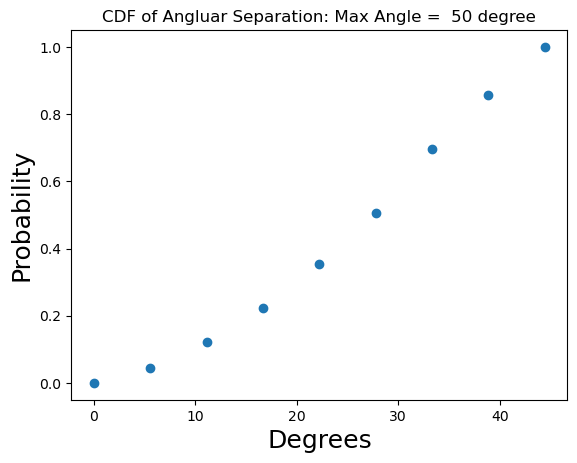

In [52]:

plt.scatter(angles * 360/(2*np.pi), output)


plt.ylabel('Probability',fontsize=18)
plt.xlabel('Degrees',fontsize=18)
plt.title('CDF of Angluar Separation: Max Angle =  ' + str(degree_max) + ' degree')
# plt.text(30, 0.25, chi_strnew, fontsize=9,bbox = dict(facecolor = 'white', alpha = 0.5))


In [21]:
index = 10


agnra = agn['ra'][index]
agndec = agn['dec'][index]

diffra = abs((gal['ra'] - agnra)).min()
diffdec = abs((gal['dec'] - agndec)).min()

sep = math.sqrt(math.pow(diffra,2) + math.pow(diffdec,2))


print(arr)

[7.62512305e-03 1.63869228e-02 9.83520381e-03 7.51237009e-03
 3.20988775e-03 1.38044604e-02 1.84869686e-02 8.62895226e-05
 3.77001148e-03 2.60737228e-03 6.46879441e-03]


In [8]:
kneighbors = 8
anglelimits = [[0.03525424, 0.2120339 ],
 [0.08576271, 0.26254237],
 [0.11101695, 0.31305085],
 [0.16152542, 0.33830508],
 [0.18677966, 0.38881356],
 [0.2120339 , 0.4140678 ],
 [0.23728814, 0.43932203],
 [0.28779661, 0.48983051]]

anglestemp = np.linspace(0.01, 0.5, 60)
angles = anglestemp[:-1]

for i in range(len(anglestemp)):
    anglestemp[i] = round(anglestemp[i],5)
    
anglestemp.shape

(60,)

In [9]:
# Find midpoints in logspace and add them to a list of rs to sample for each neighbors
midpoints = np.array([])
for i in range(kneighbors):
    midway = (anglelimits[i][0] + anglelimits[i][1])/2
    midpoints = np.append(midpoints, midway)
    
rslistvalues = np.array([(0,0,0)])
for i in range(kneighbors):
    rslistvalues = np.append(rslistvalues, [(round(anglelimits[i][0], 5), 
                                                  round(midpoints[i], 5), round(anglelimits[i][1], 5))],axis=0)
    
rslistvalues = rslistvalues[1:]
print(rslistvalues)
print(anglestemp)

[[0.03525 0.12364 0.21203]
 [0.08576 0.17415 0.26254]
 [0.11102 0.21203 0.31305]
 [0.16153 0.24992 0.33831]
 [0.18678 0.2878  0.38881]
 [0.21203 0.31305 0.41407]
 [0.23729 0.33831 0.43932]
 [0.2878  0.38881 0.48983]]
[0.01    0.01831 0.02661 0.03492 0.04322 0.05153 0.05983 0.06814 0.07644
 0.08475 0.09305 0.10136 0.10966 0.11797 0.12627 0.13458 0.14288 0.15119
 0.15949 0.1678  0.1761  0.18441 0.19271 0.20102 0.20932 0.21763 0.22593
 0.23424 0.24254 0.25085 0.25915 0.26746 0.27576 0.28407 0.29237 0.30068
 0.30898 0.31729 0.32559 0.3339  0.3422  0.35051 0.35881 0.36712 0.37542
 0.38373 0.39203 0.40034 0.40864 0.41695 0.42525 0.43356 0.44186 0.45017
 0.45847 0.46678 0.47508 0.48339 0.49169 0.5    ]


In [10]:
angleslist = np.empty((kneighbors,len(anglestemp)),dtype=bool)
for i in range(kneighbors):
    index = 0
    for j in range(len(anglestemp)):
        if(j == len(anglestemp)-1):
            angleslist[i,j] = True
        elif(index == 3):
            angleslist[i,j] = False
        elif(round(rslistvalues[i][index], 2) == round(anglestemp[j], 2)):
            angleslist[i,j] = True
            index+=1
        else:
            angleslist[i,j] = False
            

for i in range(len(angleslist)):
    count=0
    for j in range(len(angleslist[0])):
        if(angleslist[i,j] == True):
            count+=1
    print(count)

4
4
4
4
4
4
4
4


In [12]:
anglestemp = np.linspace(0.01, 0.2, 40)
angles = anglestemp[:-1]


outputhightemp, errhightemp, covhigh = k.angular_kNN_wrapper(anglestemp, up, gal, kneighbors,
                                                             angleslist, concatenate = False, m=5)
outputlowtemp, errlowtemp, covlow =  k.angular_kNN_wrapper(anglestemp, l, gal, kneighbors,
                                                             angleslist, concatenate = False, m=5)

Ngal 212 Nrand 38567 8
build tree 0.00035572052001953125
query 0.30759572982788086
  kdtree tot 0.30805492401123047
(38567, 8) [0.         0.01       0.01487179 0.01974359 0.02461538 0.02948718
 0.03435897 0.03923077 0.04410256 0.04897436 0.05384615 0.05871795
 0.06358974 0.06846154 0.07333333 0.07820513 0.08307692 0.08794872
 0.09282051 0.09769231 0.1025641  0.1074359  0.11230769 0.11717949
 0.12205128 0.12692308 0.13179487 0.13666667 0.14153846 0.14641026
 0.15128206 0.15615384 0.16102564 0.16589743 0.17076923 0.17564103
 0.18051282 0.18538462 0.19025642 0.1951282  0.2       ]
  cdf 0.018717288970947266
Using  25  jacknife samples
1 / 25
Ngal 209 Nrand 37881 8
build tree 0.0002925395965576172
query 0.2781987190246582
  kdtree tot 0.27858781814575195
(37881, 8) [0.         0.01       0.01487179 0.01974359 0.02461538 0.02948718
 0.03435897 0.03923077 0.04410256 0.04897436 0.05384615 0.05871795
 0.06358974 0.06846154 0.07333333 0.07820513 0.08307692 0.08794872
 0.09282051 0.09769231 0.1

/home/almhatre/data/AGNclustering/angular_kNN.py:45: RuntimeWarning: invalid value encountered in divide
  cdfs[ik] = dist_cdf_k / dist_cdf_k[-1]


query 0.2548515796661377
  kdtree tot 0.2552225589752197
(35700, 8) [0.         0.01       0.01487179 0.01974359 0.02461538 0.02948718
 0.03435897 0.03923077 0.04410256 0.04897436 0.05384615 0.05871795
 0.06358974 0.06846154 0.07333333 0.07820513 0.08307692 0.08794872
 0.09282051 0.09769231 0.1025641  0.1074359  0.11230769 0.11717949
 0.12205128 0.12692308 0.13179487 0.13666667 0.14153846 0.14641026
 0.15128206 0.15615384 0.16102564 0.16589743 0.17076923 0.17564103
 0.18051282 0.18538462 0.19025642 0.1951282  0.2       ]
  cdf 0.017097949981689453
5 / 25
Ngal 210 Nrand 38374 8
build tree 0.00031447410583496094
query 0.2661471366882324
  kdtree tot 0.2665715217590332
(38374, 8) [0.         0.01       0.01487179 0.01974359 0.02461538 0.02948718
 0.03435897 0.03923077 0.04410256 0.04897436 0.05384615 0.05871795
 0.06358974 0.06846154 0.07333333 0.07820513 0.08307692 0.08794872
 0.09282051 0.09769231 0.1025641  0.1074359  0.11230769 0.11717949
 0.12205128 0.12692308 0.13179487 0.13666667 0

query 0.24794697761535645
  kdtree tot 0.24832987785339355
(36569, 8) [0.         0.01       0.01487179 0.01974359 0.02461538 0.02948718
 0.03435897 0.03923077 0.04410256 0.04897436 0.05384615 0.05871795
 0.06358974 0.06846154 0.07333333 0.07820513 0.08307692 0.08794872
 0.09282051 0.09769231 0.1025641  0.1074359  0.11230769 0.11717949
 0.12205128 0.12692308 0.13179487 0.13666667 0.14153846 0.14641026
 0.15128206 0.15615384 0.16102564 0.16589743 0.17076923 0.17564103
 0.18051282 0.18538462 0.19025642 0.1951282  0.2       ]
  cdf 0.016668319702148438
19 / 25
Ngal 205 Nrand 36351 8
build tree 0.0002758502960205078
query 0.24406003952026367
  kdtree tot 0.24443721771240234
(36351, 8) [0.         0.01       0.01487179 0.01974359 0.02461538 0.02948718
 0.03435897 0.03923077 0.04410256 0.04897436 0.05384615 0.05871795
 0.06358974 0.06846154 0.07333333 0.07820513 0.08307692 0.08794872
 0.09282051 0.09769231 0.1025641  0.1074359  0.11230769 0.11717949
 0.12205128 0.12692308 0.13179487 0.136666

query 0.23937630653381348
  kdtree tot 0.23974370956420898
(37771, 8) [0.         0.01       0.01487179 0.01974359 0.02461538 0.02948718
 0.03435897 0.03923077 0.04410256 0.04897436 0.05384615 0.05871795
 0.06358974 0.06846154 0.07333333 0.07820513 0.08307692 0.08794872
 0.09282051 0.09769231 0.1025641  0.1074359  0.11230769 0.11717949
 0.12205128 0.12692308 0.13179487 0.13666667 0.14153846 0.14641026
 0.15128206 0.15615384 0.16102564 0.16589743 0.17076923 0.17564103
 0.18051282 0.18538462 0.19025642 0.1951282  0.2       ]
  cdf 0.017708778381347656
7 / 25
Ngal 206 Nrand 37024 8
build tree 0.00030422210693359375
query 0.24774646759033203
  kdtree tot 0.24816536903381348
(37024, 8) [0.         0.01       0.01487179 0.01974359 0.02461538 0.02948718
 0.03435897 0.03923077 0.04410256 0.04897436 0.05384615 0.05871795
 0.06358974 0.06846154 0.07333333 0.07820513 0.08307692 0.08794872
 0.09282051 0.09769231 0.1025641  0.1074359  0.11230769 0.11717949
 0.12205128 0.12692308 0.13179487 0.136666

/home/almhatre/data/AGNclustering/angular_kNN.py:45: RuntimeWarning: invalid value encountered in divide
  cdfs[ik] = dist_cdf_k / dist_cdf_k[-1]


query 0.2426314353942871
  kdtree tot 0.2429962158203125
(37284, 8) [0.         0.01       0.01487179 0.01974359 0.02461538 0.02948718
 0.03435897 0.03923077 0.04410256 0.04897436 0.05384615 0.05871795
 0.06358974 0.06846154 0.07333333 0.07820513 0.08307692 0.08794872
 0.09282051 0.09769231 0.1025641  0.1074359  0.11230769 0.11717949
 0.12205128 0.12692308 0.13179487 0.13666667 0.14153846 0.14641026
 0.15128206 0.15615384 0.16102564 0.16589743 0.17076923 0.17564103
 0.18051282 0.18538462 0.19025642 0.1951282  0.2       ]
  cdf 0.017452478408813477
18 / 25
Ngal 205 Nrand 36569 8
build tree 0.0002830028533935547
query 0.24170637130737305
  kdtree tot 0.24208927154541016
(36569, 8) [0.         0.01       0.01487179 0.01974359 0.02461538 0.02948718
 0.03435897 0.03923077 0.04410256 0.04897436 0.05384615 0.05871795
 0.06358974 0.06846154 0.07333333 0.07820513 0.08307692 0.08794872
 0.09282051 0.09769231 0.1025641  0.1074359  0.11230769 0.11717949
 0.12205128 0.12692308 0.13179487 0.13666667

/home/almhatre/data/AGNclustering/angular_kNN.py:45: RuntimeWarning: invalid value encountered in divide
  cdfs[ik] = dist_cdf_k / dist_cdf_k[-1]


query 0.24279093742370605
  kdtree tot 0.24316787719726562
(36461, 8) [0.         0.01       0.01487179 0.01974359 0.02461538 0.02948718
 0.03435897 0.03923077 0.04410256 0.04897436 0.05384615 0.05871795
 0.06358974 0.06846154 0.07333333 0.07820513 0.08307692 0.08794872
 0.09282051 0.09769231 0.1025641  0.1074359  0.11230769 0.11717949
 0.12205128 0.12692308 0.13179487 0.13666667 0.14153846 0.14641026
 0.15128206 0.15615384 0.16102564 0.16589743 0.17076923 0.17564103
 0.18051282 0.18538462 0.19025642 0.1951282  0.2       ]
  cdf 0.017614126205444336
24 / 25
Ngal 204 Nrand 37096 8
build tree 0.00029015541076660156
query 0.26127028465270996
  kdtree tot 0.26167964935302734
(37096, 8) [0.         0.01       0.01487179 0.01974359 0.02461538 0.02948718
 0.03435897 0.03923077 0.04410256 0.04897436 0.05384615 0.05871795
 0.06358974 0.06846154 0.07333333 0.07820513 0.08307692 0.08794872
 0.09282051 0.09769231 0.1025641  0.1074359  0.11230769 0.11717949
 0.12205128 0.12692308 0.13179487 0.13666

In [13]:
outputhigh = np.delete(outputhightemp, -1, axis=1)

outputlow = np.delete(outputlowtemp, -1, axis=1)

errhigh = np.delete(errhightemp, -1, axis=1)

errlow = np.delete(errlowtemp, -1, axis=1)

In [17]:
print(angles * 360/(2*math.pi))

[ 0.5729578   0.85209108  1.13122436  1.41035765  1.68949093  1.96862422
  2.2477575   2.52689079  2.80602407  3.08515736  3.36429064  3.64342393
  3.92255721  4.2016905   4.48082378  4.75995707  5.03909035  5.31822364
  5.59735692  5.87649021  6.15562349  6.43475678  6.71389006  6.99302335
  7.27215663  7.55128992  7.8304232   8.10955648  8.38868977  8.66782305
  8.94695634  9.22608962  9.50522291  9.78435619 10.06348948 10.34262276
 10.62175605 10.90088933 11.18002262]


In [14]:
conditionhigh = np.linalg.cond(covhigh)
conditionlow = np.linalg.cond(covlow)

LinAlgError: SVD did not converge

In [13]:
print("condition number of high mass subsample: " , conditionhigh)
print("condition number of low mass subsample: " , conditionlow)
print(angles)

condition number of high mass subsample:  96184.00376172566
condition number of low mass subsample:  20502.386793469588
[0.01    0.01831 0.02661 0.03492 0.04322 0.05153 0.05983 0.06814 0.07644
 0.08475 0.09305 0.10136 0.10966 0.11797 0.12627 0.13458 0.14288 0.15119
 0.15949 0.1678  0.1761  0.18441 0.19271 0.20102 0.20932 0.21763 0.22593
 0.23424 0.24254 0.25085 0.25915 0.26746 0.27576 0.28407 0.29237 0.30068
 0.30898 0.31729 0.32559 0.3339  0.3422  0.35051 0.35881 0.36712 0.37542
 0.38373 0.39203 0.40034 0.40864 0.41695 0.42525 0.43356 0.44186 0.45017
 0.45847 0.46678 0.47508 0.48339 0.49169]


In [54]:
inv = np.linalg.inv(covhigh+covlow)
orig = np.linalg.inv(inv)

[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.

In [41]:
outputhighconc = np.zeros((kneighbors,3))
for i in range(kneighbors):
    outputhighconc[i] = outputhigh[i][angleslist[i][:-1]]
    
    
outputlowconc = np.zeros((kneighbors,3))
for i in range(kneighbors):
    outputlowconc[i] = outputlow[i][angleslist[i][:-1]]
    

Text(0.22, 0.1, 'chi_squared: 20.045342203068582')

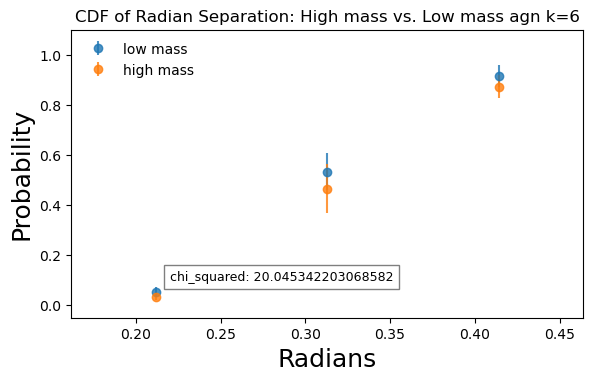

In [50]:
neighbor = 6

ind = neighbor - 1



fig1 = plt.figure(1)
frame1=fig1.add_axes((.1,.3,.8,.6),yticks=[.0,.2,.4,.6,.8,1.0])
plt.errorbar(rslistvalues[ind],outputlowconc[ind],yerr=errlow[ind],fmt='o',label='low mass',alpha=0.8)
plt.errorbar(rslistvalues[ind],outputhighconc[ind],yerr=errhigh[ind],fmt='o',label='high mass',alpha=0.8)
plt.legend(frameon=False,numpoints=1,loc=2)
plt.title('CDF of Radian Separation: High mass vs. Low mass agn k=' + str(neighbor))
plt.ylabel('Probability',fontsize=18)
plt.xlabel('Radians',fontsize=18)

plt.axis([rslistvalues[ind][0] - 0.05, rslistvalues[ind][-1] + 0.05,-.05,1.1])

chi_squared = kNN_chi_squared(outputlowconc,outputhighconc,covlow,covhigh,concatenate=True)


# chi_squared = kNN_chi_squared(outputhighconc,outputlowconc,covhigh,covlow,concatenate=True)
chi_strnew = 'chi_squared: '+ str(chi_squared)
plt.text(0.22, 0.1, chi_strnew, fontsize=9,bbox = dict(facecolor = 'white', alpha = 0.5))


(-0.42704220486917677, 12.18002261780914, -0.05, 1.1)

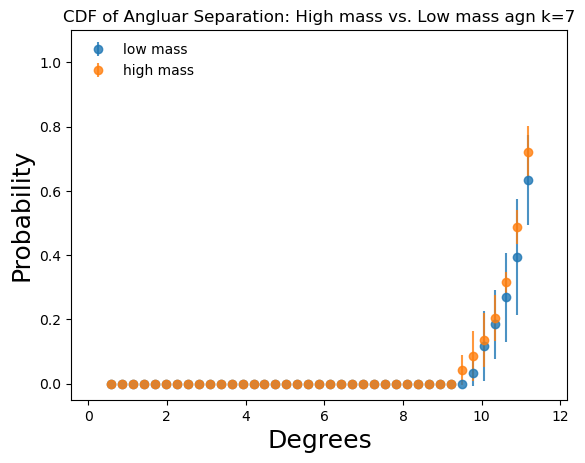

In [50]:
neighbor = 7

anglemax = angles[-1] * 360/(2*math.pi)
anglemin = angles[0] * 360/(2*math.pi)

ind = neighbor - 1



plt.errorbar(angles * 360/(2*math.pi), outputlow[ind], yerr=errlow[ind],fmt='o',label='low mass',alpha=0.8)
plt.errorbar(angles * 360/(2*math.pi), outputhigh[ind], yerr=errhigh[ind],fmt='o',label='high mass',alpha=0.8)

plt.ylabel('Probability',fontsize=18)
plt.xlabel('Degrees',fontsize=18)
plt.legend(frameon=False,numpoints=1,loc=2)
plt.title('CDF of Angluar Separation: High mass vs. Low mass agn k=' + str(neighbor))
# plt.text(30, 0.25, chi_strnew, fontsize=9,bbox = dict(facecolor = 'white', alpha = 0.5))
plt.axis([anglemin - 1, anglemax + 1,-.05,1.1])



# chi_squared = kNN_chi_squared(outputhigh[ind],outputlow[ind],covhigh[ind],covlow[ind],single_neighbor=True)
# chi_strnew = 'chi_squared: '+ str(chi_squared)
# plt.text(0.22, 0.1, chi_strnew, fontsize=9,bbox = dict(facecolor = 'white', alpha = 0.5))


/data/almhatre/miniconda3/lib/python3.10/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


NameError: name 'anglemin' is not defined

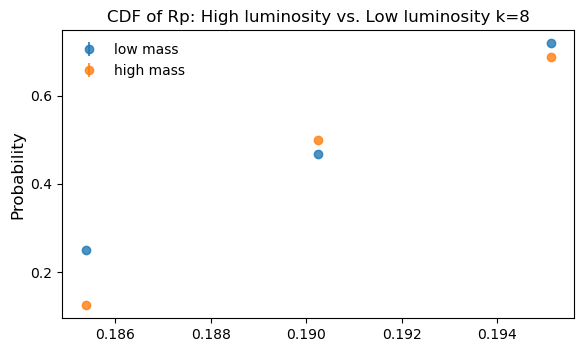

In [18]:
neighbor = 8

ind = neighbor - 1


anglesnew,highnew,lownew,errhighnew, errlownew, covhighnew,covlownew = \
angular_chop_cdf(angles,outputhigh[ind],outputlow[ind],errhigh[ind],errlow[ind],covhigh[ind],covlow[ind])


addit = [(anglesnew[0],anglesnew[-1])]


anglelimits = np.append(anglelimits,addit,axis=0)

fig1 = plt.figure(1)
frame1=fig1.add_axes((.1,.3,.8,.6),yticks=[.0,.2,.4,.6,.8,1.0])
plt.errorbar(anglesnew,lownew,yerr=errlownew,fmt='o',label='low mass',alpha=0.8)
plt.errorbar(anglesnew,highnew,yerr=errhighnew,fmt='o',label='high mass',alpha=0.8)
plt.ylabel('Probability',fontsize=12)
plt.legend(frameon=False,numpoints=1,loc=2)
plt.title('CDF of Rp: High luminosity vs. Low luminosity k=' + str(neighbor))
# plt.text(30, 0.25, chi_strnew, fontsize=9,bbox = dict(facecolor = 'white', alpha = 0.5))

plt.axis([anglemin - 0.05, anglemax + 0.05,-.05,1.1])

print(anglelimits)